In [44]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import codecs as cd
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import log_loss,confusion_matrix
import seaborn as sns

from sklearn.feature_selection import SelectFromModel

from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,GridSearchCV

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression

from  sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix # 回帰問題における性能評価に関する関数

In [2]:
#データ読み込み
df_demo = pd.read_csv("ks-projects-201801.csv/ks-projects-201801.csv")
#最初の5行を表示
display(df_demo.head())

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


In [3]:
#欠損値がある行数を確認
display(df_demo.isnull().sum())
#各列のデータタイプを確認
display(df_demo.dtypes)

ID                     0
name                   4
category               0
main_category          0
currency               0
deadline               0
goal                   0
launched               0
pledged                0
state                  0
backers                0
country                0
usd pledged         3797
usd_pledged_real       0
usd_goal_real          0
dtype: int64

ID                    int64
name                 object
category             object
main_category        object
currency             object
deadline             object
goal                float64
launched             object
pledged             float64
state                object
backers               int64
country              object
usd pledged         float64
usd_pledged_real    float64
usd_goal_real       float64
dtype: object

In [4]:
#欠損値がある行を削除
df=df_demo.dropna(how='any')
#欠損値がある行数を数える
display(df.isnull().sum())

ID                  0
name                0
category            0
main_category       0
currency            0
deadline            0
goal                0
launched            0
pledged             0
state               0
backers             0
country             0
usd pledged         0
usd_pledged_real    0
usd_goal_real       0
dtype: int64

In [5]:
#stateの要素の個数を数える
df['state'].value_counts()

failed        197611
successful    133851
canceled       38757
live            2798
suspended       1843
Name: state, dtype: int64

In [6]:
#成功だけを抽出したDFと失敗だけを抽出したDF
df_SorF = df[df["state"].isin(["successful","failed"])]

df_SorF.loc[df_SorF["state"]=="successful","state"]=1
df_SorF.loc[df_SorF["state"]=="failed","state"]=0
#stateの要素の個数を数えてみる。
df_SorF['state'].value_counts()

C:\Users\N397\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


0    197611
1    133851
Name: state, dtype: int64

In [7]:
use_col = ["main_category", "currency","country"]
use_col

['main_category', 'currency', 'country']

In [8]:
# ダミー変数実装

df_dum=pd.get_dummies(df_SorF[use_col],columns=["main_category","currency","country"])


## 特徴選択

In [9]:
#ランダムフォレスト使用
estimator = RandomForestClassifier(n_estimators=10, max_depth=10, criterion="gini", min_samples_split=2, random_state=1234, min_samples_leaf=5, n_jobs=-1)

rfecv = RFECV(estimator, cv=10, scoring='accuracy')

In [10]:
#目的変数'state'を正解としてyに格納
y = df_SorF['state'].values
#説明変数'main_category','currency','country'を入力としてXに格納
X = df_dum.values

In [11]:
rfecv.fit(X, y)

RFECV(cv=10,
      estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                       criterion='gini', max_depth=10,
                                       max_features='auto', max_leaf_nodes=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=5, min_samples_split=2,
                                       min_weight_fraction_leaf=0.0,
                                       n_estimators=10, n_jobs=-1,
                                       oob_score=False, random_state=1234,
                                       verbose=0, warm_start=False),
      min_features_to_select=1, n_jobs=None, scoring='accuracy', step=1,
      verbose=0)

In [12]:
# 特徴のランキングを表示（1が最も重要な特徴）
print('Feature ranking: \n{}'.format(rfecv.ranking_))

Feature ranking: 
[ 1  1  1  1  1  1  1  1  1  1  1 10  1  1  1  7  1 25 15  1  1 12 31  4
 17 26 19 27  1 21  2 24  6 16  5 23  9  3  1 13 14  1 30 28  8 11 29 18
 20 22  1]


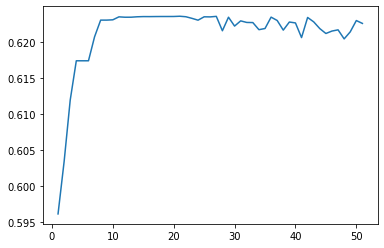

In [13]:
# 特徴数とスコアの変化をプロット
# 負のMAEが評価基準になっており，値がゼロに近いほど汎化誤差は小さい
#x軸が12.5あたりが一番いい結果になっている(12.5以上は候補としては置いておいていい)
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [14]:
# bool型の配列に ~ をつけるとTrueとFalseを反転させることができる
# ここでTrueになっている特徴が削除してもよい特徴
drop_idx = ~rfecv.support_
drop_idx


array([False, False, False, False, False, False, False, False, False,
       False, False,  True, False, False, False,  True, False,  True,
        True, False, False,  True,  True,  True,  True,  True,  True,
        True, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False,  True,  True, False,  True,  True,  True,
        True,  True,  True,  True,  True, False])

In [18]:
# 削除してもよい特徴の名前を取得する
drop_name=df_dum.columns[drop_idx]
drop_name

Index(['main_category_Photography', 'currency_AUD', 'currency_CHF',
       'currency_DKK', 'currency_HKD', 'currency_JPY', 'currency_MXN',
       'currency_NOK', 'currency_NZD', 'currency_SEK', 'currency_SGD',
       'country_AT', 'country_AU', 'country_BE', 'country_CA', 'country_CH',
       'country_DE', 'country_DK', 'country_ES', 'country_FR', 'country_HK',
       'country_IE', 'country_JP', 'country_LU', 'country_MX', 'country_NL',
       'country_NO', 'country_NZ', 'country_SE', 'country_SG'],
      dtype='object')

In [20]:
# drop関数で特徴を削除
selected_X_train= df_dum.drop(drop_name, axis=1)
selected_X_train

,main_category_Art,main_category_Comics,main_category_Crafts,main_category_Dance,main_category_Design,main_category_Fashion,main_category_Film & Video,main_category_Food,main_category_Games,main_category_Journalism,...,main_category_Publishing,main_category_Technology,main_category_Theater,currency_CAD,currency_EUR,currency_GBP,currency_USD,country_GB,country_IT,country_US
0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,1,0,0
1,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,1
2,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
5,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,1
6,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,1
7,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,1
10,0,0,0,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,0
11,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
12,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1


In [22]:
#学習用データ、テストデータに分ける
X = selected_X_train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1234)

In [45]:
###------
###決定木
###------
import graphviz
import pydotplus
from IPython.display import Image
from sklearn.externals.six import StringIO
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(criterion="gini", max_depth=2, min_samples_split=2, min_samples_leaf=3, random_state=1234)
clf = clf.fit(X_train, y_train)
print("score=", clf.score(X_train, y_train))
y_pred_train = clf.predict(X_train)
print('訓練誤差')
# ラベルを予測
y_pred = clf.predict(X)

# 正答率を計算
accuracy =  accuracy_score(y, y_pred)
print('正答率（Accuracy） = {:.3f}%'.format(100 * accuracy))

# Precision, Recall, F1-scoreを計算
precision, recall, f1_score, _ = precision_recall_fscore_support(y, y_pred)

# カテゴリ「2000万以上」に関するPrecision, Recall, F1-scoreを表示
print('適合率（Precision） = {:.3f}%'.format(100 * precision[0]))
print('再現率（Recall） = {:.3f}%'.format(100 * recall[0]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[0]))

score= 0.6023713166367127
訓練誤差
正答率（Accuracy） = 60.345%
適合率（Precision） = 61.582%
再現率（Recall） = 89.021%
F1値（F1-score） = 72.802%


In [46]:
###------
###ランダムフォレスト
###------
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=10, max_depth=2, criterion="gini",min_samples_leaf=2, min_samples_split=2, random_state=1234)
clf.fit(X_train, y_train)
print("score=", clf.score(X_train, y_train))
y_pred_train = clf.predict(X_train)
print('訓練誤差')
# ラベルを予測
y_pred = clf.predict(X)

# 正答率を計算
accuracy =  accuracy_score(y, y_pred)
print('正答率（Accuracy） = {:.3f}%'.format(100 * accuracy))

# Precision, Recall, F1-scoreを計算
precision, recall, f1_score, _ = precision_recall_fscore_support(y, y_pred)

# カテゴリ「2000万以上」に関するPrecision, Recall, F1-scoreを表示
print('適合率（Precision） = {:.3f}%'.format(100 * precision[0]))
print('再現率（Recall） = {:.3f}%'.format(100 * recall[0]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[0]))

score= 0.594975498118721
訓練誤差
正答率（Accuracy） = 59.618%
適合率（Precision） = 59.618%
再現率（Recall） = 100.000%
F1値（F1-score） = 74.701%


C:\Users\N397\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [25]:
###------
###NN
###------
import tensorflow as tf
from sklearn.metrics import accuracy_score,f1_score,recall_score,precision_score,classification_report
from sklearn.metrics import confusion_matrix
from tensorflow import keras  
from tensorflow.compat.v1.keras import Sequential
from tensorflow.compat.v1.keras.layers import Dense, Dropout, Activation
from tensorflow.compat.v1.keras.optimizers import SGD,RMSprop, Adagrad, Adadelta, Adam
import keras

Using TensorFlow backend.


In [32]:
model = Sequential()
model.add(Dense(16, activation='relu', input_dim=21))
model.add(Dense(8, activation='relu', input_dim=16))
model.add(Dense(2, activation='softmax'))#最終層のactivationは変更しないこと

# ------ 最適化手法 ------
sgd = SGD(lr=0.01, momentum=0.9, nesterov=False)
# rms = RMSprop(lr=0.01)
# adag = Adagrad(lr=0.01)
# adad = Adadelta(lr=0.01)
# adam = Adam(lr=0.01)
# -----------------------------

model.compile(loss='sparse_categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

# WARNINGが出るが気にしなくて良い

Train on 232023 samples, validate on 99439 samples
Epoch 1/10
232023/232023 [==============================] - 10s 41us/sample - loss: 0.6536 - acc: 0.6174 - val_loss: 0.6481 - val_acc: 0.6252
Epoch 2/10
232023/232023 [==============================] - 9s 41us/sample - loss: 0.6512 - acc: 0.6212 - val_loss: 0.6495 - val_acc: 0.6253
Epoch 3/10
232023/232023 [==============================] - 9s 41us/sample - loss: 0.6511 - acc: 0.6212 - val_loss: 0.6490 - val_acc: 0.6251.6512 - acc: 0.
Epoch 4/10
232023/232023 [==============================] - 9s 40us/sample - loss: 0.6509 - acc: 0.6217 - val_loss: 0.6480 - val_acc: 0.6252
Epoch 5/10
232023/232023 [==============================] - 10s 42us/sample - loss: 0.6508 - acc: 0.6217 - val_loss: 0.6484 - val_acc: 0.6253
Epoch 6/10
232023/232023 [==============================] - 10s 42us/sample - loss: 0.6509 - acc: 0.6217 - val_loss: 0.6491 - val_acc: 0.6254
Epoch 7/10
232023/232023 [==============================] - 10s 44us/sample - loss: 0

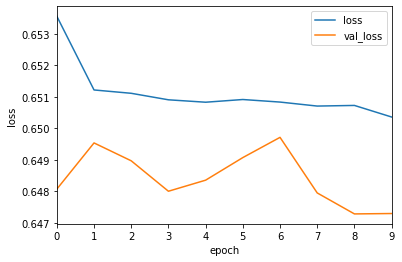

In [34]:
#計算の実行
fit = model.fit(X_train, y_train, epochs=10,batch_size=20,validation_data=(X_test, y_test))

# 各epochにおける損失と精度をdfに入れる
df = pd.DataFrame(fit.history)

# グラフ化
df[["loss", "val_loss"]].plot()
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

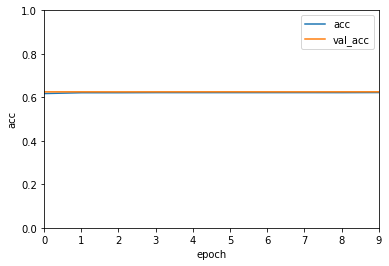

In [39]:
df[["acc", "val_acc"]].plot()
plt.ylabel("acc")
plt.xlabel("epoch")
plt.ylim([0,1.0])
plt.show()

In [40]:
###------
###ロジスティック回帰  
###------
# clf = SGDClassifier(loss='log', penalty='none', max_iter=1000, fit_intercept=True, random_state=1234)

# #clf.fit(X_test, y_test) 使わない
# clf.fit(selected_X_train, y_train)

ValueError: Found input variables with inconsistent numbers of samples: [331462, 232023]

ニューラルネットワークがうまくいかなかったため途中での提出になっています

また、説明変数、特徴選択の方法あ違うため比較対象として不十分だと思ったため第2回との比較はあまり意味をなさないと思いましたが下記に第2回との比較として記しておきます

第2回課題<br>
Accuracy  = 59.671%<br>
Recall    = 0.173%<br>
Precision = 85.926%<br>
<br>
決定木<br>
正答率（Accuracy） = 60.345%<br>
適合率（Precision） = 61.582%<br>
再現率（Recall） = 89.021%<br>
F1値（F1-score） = 72.802%<br>
<br>
ランダムフォレスト<br>
正答率（Accuracy） = 59.618%<br>
適合率（Precision） = 59.618%<br>
再現率（Recall） = 100.000%<br>
F1値（F1-score） = 74.701%